#  Water Classification <img align="right" src="image/gistda.png" width="200" height="200">

This case study classify water area by using Machine Learning method That is Random Forest classification.

The Random forest classifier creates a set of decision trees from a randomly selected subset of the training set. 

It is basically a set of decision trees from a randomly selected subset of the training set 
and then It collects the votes from different decision trees to decide the final prediction.



<table class="ee-notebook-buttons" align="left">
    <td><a target="_parent"  href="https://nbviewer.org/github/DreamPTK/rice-detection/blob/main/Tutorial/Water_classification.ipynb"><img width=26px src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/38/Jupyter_logo.svg/883px-Jupyter_logo.svg.png" />Notebook Viewer</a></td>
</table>


## Import Package

In [53]:
import datacube
import matplotlib
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from odc.io.cgroups import get_cpu_quota
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from datacube.utils import geometry
from datacube.utils.cog import write_cog
from dea_tools.classification import collect_training_data, predict_xr
from dream_river.plotimg import show_map, show_vector, geojson_add_Newcol 
from dream_river.geobox import merge, convert_geojson_CRS

import warnings
warnings.filterwarnings("ignore")

## Connect to datacube

In [3]:
dc = datacube.Datacube(app='classify_water')

## Create training data (Draw polygons) 

The Drawing tool was used to create trianing data on your specific area. This case study created 2 types of landuse to train the model that compose of water and not-water.


In [4]:
Map =show_map()
Map

### Display output from drawing

In [5]:
# get path of files
path = ['training/water_Kan.geojson','training/NonWater_Kan.geojson']
show_vector(path)

## Data preparation

#### - Add new column

In this case study, we create "class" in column name and add value into that column follow file name to categorize the type of data like: 

water = 111

non-water = 222

In [7]:
# func to add new colume and assign value
geojson_add_Newcol('training/water_Kan.geojson')

num of rows:  33


Enter the name of the new column:  class
Enter the value for the new column:  111


33

In [8]:
# func to add new colume and assign value
geojson_add_Newcol('training/NonWater_Kan.geojson')

num of rows:  32


Enter the name of the new column:  class
Enter the value for the new column:  222


32

### - Explore new column

You will see new column was created

In [9]:
data = gpd.read_file('training/water_Kan.geojson')
data.head()

,class,geometry
0,111,"POLYGON ((99.03857 14.58151, 99.03857 14.59148..."
1,111,"POLYGON ((99.03038 14.66447, 99.03038 14.67444..."
2,111,"POLYGON ((99.03571 14.72446, 99.03571 14.72949..."
3,111,"POLYGON ((99.04726 14.80157, 99.04726 14.80397..."
4,111,"POLYGON ((99.04447 14.82606, 99.04447 14.82807..."


In [10]:
data_2 = gpd.read_file('training/NonWater_Kan.geojson')
data_2.head()

,class,geometry
0,222,"POLYGON ((98.87966 14.74162, 98.87966 14.74359..."
1,222,"POLYGON ((98.86965 14.74677, 98.86965 14.74747..."
2,222,"POLYGON ((98.86146 14.74830, 98.86146 14.74961..."
3,222,"POLYGON ((98.91787 14.73683, 98.91787 14.74013..."
4,222,"POLYGON ((98.95223 14.70406, 98.95223 14.71136..."


### - Merge data 

The three geojson files was created follow above steps, We need to merge them together to train classification model.

In [11]:
# assige input path
file =['training/water_Kan.geojson','training/NonWater_Kan.geojson']

# assign output file path
output = 'training/WaterModel_training.geojson'

# merge function
merge(file,output)

### - Explore merge output

In [19]:
merge_out = gpd.read_file('training/WaterModel_training.geojson')

# merge_out.tail()
merge_out.head()

,class,geometry
0,111,"POLYGON ((99.03857 14.58151, 99.03857 14.59148..."
1,111,"POLYGON ((99.03038 14.66447, 99.03038 14.67444..."
2,111,"POLYGON ((99.03571 14.72446, 99.03571 14.72949..."
3,111,"POLYGON ((99.04726 14.80157, 99.04726 14.80397..."
4,111,"POLYGON ((99.04447 14.82606, 99.04447 14.82807..."


### - Convert Geo Coodinate Refference System(CRS)

This case study have to convert the CRS from 4326 to 32647 to access the data cube of Gistda.

In [20]:
# check coordinate system of data
merge_out.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [21]:
# set input output path
input_path = 'training/WaterModel_training.geojson'
output_path = 'training/WaterModel_32647.geojson'

# function to convert CRS
convert_geojson_CRS(input_path, output_path, crs=32647)

In [22]:
# explore output 
crs_out = gpd.read_file(output_path)
crs_out.crs

<Derived Projected CRS: EPSG:32647>
Name: WGS 84 / UTM zone 47N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 96°E and 102°E, northern hemisphere between equator and 84°N, onshore and offshore. China. Indonesia. Laos. Malaysia - West Malaysia. Mongolia. Myanmar (Burma). Russian Federation. Thailand.
- bounds: (96.0, 0.0, 102.0, 84.0)
Coordinate Operation:
- name: UTM zone 47N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Extract training data using a shapefile

To train our model, we need to obtain satellite data that corresponds with the labelled input data locations above. 
The function below takes our shapefile containing class labels and extracts the specified product within these areas into a single array.

### Set Parameter

In [47]:
field = 'class'
time = ("2018-01-15","2018-01-20")
zonal_stats = 'median'
resolution = (-30, 30)
output_crs= "EPSG:32647"

In [24]:
# Generate a new datacube query object
query = {
    "measurements": ['red','green','blue',"nir"],
    'time': time,
    'resolution': resolution,
    'output_crs': output_crs,
    'group_by': 'solar_day',
}

In [29]:
# Load input data shapefile
input_data = gpd.read_file('training/WaterModel_32647.geojson')

# Plot first five rows
input_data.head()

,class,geometry
0,111,"POLYGON ((504154.733 1612040.005, 504154.546 1..."
1,111,"POLYGON ((503270.576 1621216.091, 503270.428 1..."
2,111,"POLYGON ((503843.749 1627850.607, 503843.660 1..."
3,111,"POLYGON ((505085.781 1636379.813, 505085.725 1..."
4,111,"POLYGON ((504785.023 1639088.300, 504784.979 1..."


In [25]:
ncpus=round(get_cpu_quota())
print(ncpus)

6


The following function is passed to `collect_training_data`. 

It extracts bands from the [ls8_collections_sr_scene](https://datacube.gistda.or.th/explorer/products/ls8_collections_l1_scene) product as feature layers along side our labelled data so we can train a supervised model.

The feature function can be modified to extract different combinations of features within the datacube, it is one of the important parts to experiment with when generating your own model.

In [27]:
def custom_function(query):

    # Initialise datacube
    dc = datacube.Datacube(app='custom_feature_layers')

    # Load data using query
    result = dc.load(product='ls8_collections_sr_scene', **query)

    return result

> **Note:** The following cell can take several minutes to run. The class labels will be contained in the first column of the output array called model_input, the corresponding variable names captured in the list column_names

In [31]:
column_names, model_input = collect_training_data(gdf=input_data,
                                                  dc_query=query,
                                                  ncpus=ncpus,
                                                  feature_func=custom_function,
                                                  field=field,
                                                  zonal_stats=zonal_stats)

Taking zonal statistic: median


  0%|          | 0/65 [00:00<?, ?it/s]

Percentage of possible fails after run 1 = 0.0 %
Removed 0 rows wth NaNs &/or Infs
Output shape:  (40, 5)


## Preprocessing

Our training data has multiple classes in it.
However, we are only trying to predict one class (i.e. class label 111, _Water area_) with this model. 
We therefore remove other classes from our training data by setting the label value for all other classes to 0.

These entries provide counter-examples to help the model distinguish the landcover classes from each other.


In [32]:
# Modify the input training data for single class labels
model_input[:, 0] = np.where(model_input[:, 0] == 111, 1, 0)

In [33]:
model_input[:, 0]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.])

### Split to training data 70% and testing data 30%

So that we can access the accuracy of our classification, we split our data into training and testing data. 
70% is used for training with 30% held back for testing.
When splitting our data, we stratify the training data by the distributions of class membership.
This sampling method leads to a similar distribution of class membership in the training data.

In [34]:
# Split into training and testing data
model_train, model_test = model_selection.train_test_split(
    model_input, stratify=model_input[:, 0], train_size=0.7, random_state=0)
print("Train shape:", model_train.shape)
print("Test shape:", model_test.shape)

Train shape: (28, 5)
Test shape: (12, 5)


### Model preparation

This section automatically creates a list of variable names and their respective indices for each of the training data variables.

> **Note:** To use a custom subset of the satellite bands loaded above to train our data, you can replace `column_names[1:]` with a list of selected band names (e.g. `['red', 'green', 'blue', 'nir']`)

The Random Forest classification is a Machine learning method that was used in this case study. 

In [35]:
# Select the variables we want to use to train our model
model_variables = column_names[1:]

# Extract relevant indices from the processed shapefile
model_col_indices = [
    column_names.index(var_name) for var_name in model_variables
]

In [54]:
# Initialise model
model = RandomForestClassifier(n_estimators=500)

## Train model

The model is fitted / trained using the prepared training data. 
The fitting process uses the Random forest approach to create a generalized representation of reality based on the training data. 
This fitted / trained model can then be used to predict which class new data belongs to.

In [55]:
# Train model
model.fit(model_train[:, model_col_indices], model_train[:, 0])

RandomForestClassifier(n_estimators=500)

#### - Predict with tesing data to validate the model

In [56]:
predictions = model.predict(model_test[:, model_col_indices])

#### - Accuracy of model

In [57]:
accuracy_score(predictions, model_test[:, 0])

1.0

### Prediction

Now that we have a trained model, we can load new data and use the `predict_xr` function to predict landcover classes. 

The trained model can technically be used to classify any dataset or product with the same bands as the data originally used to train the data.
However, it is typically highly advisable to classify data from the same product that the data was originally trained on.

In [58]:
InputData = gpd.read_file('training/WaterModel_32647.geojson')

In [59]:
shape = InputData
    
# Compute the bounding box of the union of all geometries in shp
xmin, ymin, xmax, ymax = shape.unary_union.bounds
    
# Convert bounding box coordinates to decimal degrees
gdf_crs_decimal_degrees = shape.to_crs("EPSG:4326")
xmin, ymin = gdf_crs_decimal_degrees.total_bounds[:2]
xmax, ymax = gdf_crs_decimal_degrees.total_bounds[2:]

In [60]:
# Set up the query parameters
query1 = {
    "measurements": ['red','green','blue',"nir"],
    'time': time,
    'x': (xmin, xmax),
    'y': (ymin, ymax),
    'resolution': resolution,
    'output_crs': output_crs,
    'group_by': 'solar_day'}

# Use custom function to generate input data
InputData = custom_function(query1)
InputData

<xarray.Dataset>
Dimensions:      (time: 1, y: 1137, x: 2178)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-19T03:43:58
  * y            (y) float64 1.646e+06 1.646e+06 ... 1.612e+06 1.612e+06
  * x            (x) float64 4.431e+05 4.431e+05 ... 5.083e+05 5.084e+05
    spatial_ref  int32 32647
Data variables:
    red          (time, y, x) int16 287 317 345 349 349 ... 200 201 204 204 201
    green        (time, y, x) int16 431 480 530 513 501 ... 354 358 357 357 361
    blue         (time, y, x) int16 300 308 323 317 321 ... 337 336 330 331 330
    nir          (time, y, x) int16 2393 2910 3224 3092 2996 ... 123 124 126 125
Attributes:
    crs:           EPSG:32647
    grid_mapping:  spatial_ref

### - Predict 

In [61]:
# Predict landcover using the trained model
predicted = predict_xr(model, InputData, clean=True)

predicting...


### Plot output

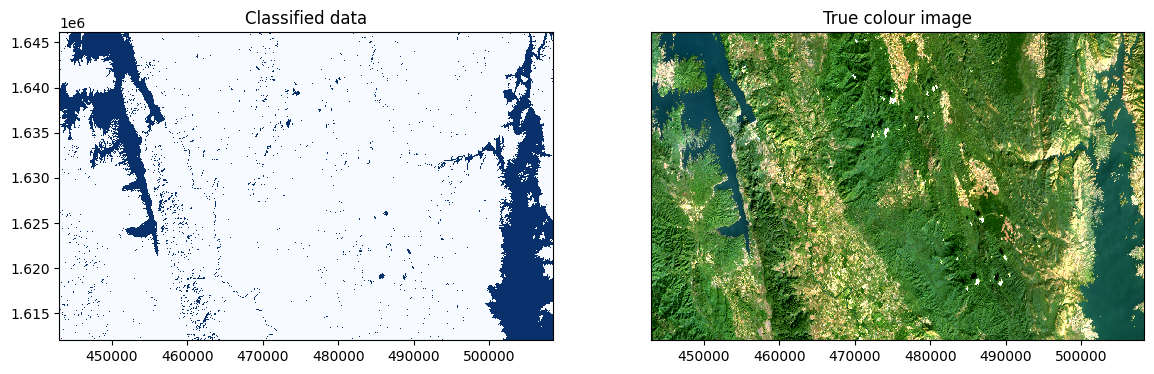

In [67]:
# Set up plot
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Plot classified image
predicted.Predictions.plot(ax=axes[0], 
               cmap='Blues', 
               add_labels=False, 
               add_colorbar=False)

# Plot true colour image
(InputData[['red', 'green', 'blue']]
 .squeeze('time')
 .to_array()
 .plot.imshow(ax=axes[1], robust=True, add_labels=False))

# Remove axis on right plot
axes[1].get_yaxis().set_visible(False)

# Add plot titles
axes[0].set_title('Classified data')
axes[1].set_title('True colour image');